<a href="https://colab.research.google.com/github/unknown-jun/NLP_study/blob/main/NLP_Book/B10_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT
BERT(Bidirectional Encoder Representations from Transformers)는 기존의 단방향 자연어 처리 모델들의 단점을 보완한 양방향 자연어 처리 모델  
검색 문장의 단어를 입력된 순서대로 하나씩 처리하는 것이 아닌, 트랜스포머를 이용하여 구현되었으며 방대한 양의 텍스트 데이터로 사전 훈련된 언어 모델

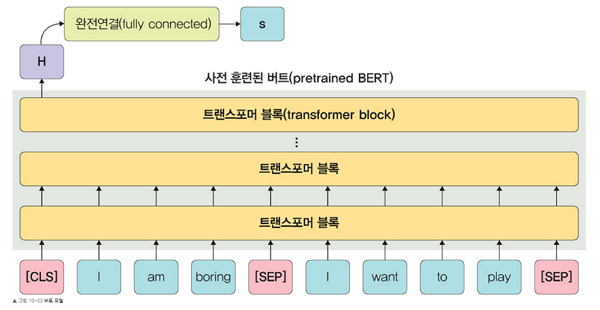

버트의 기본 구조는 위의 그림과 같이 트랜스포머(transformer) 인코더를 쌓아 올린 구조다. 주로 문장 예측(Next Sentence Prediction, NSP)을 할 때 사용한다.  튜닝을 통해 최고의 성능을 낸 기존 사례를 참고하여 사전 학습된 버트 위에 분류를 위한 신경망을 한층 추가하는 방식을 사용한다  
⇒ 즉, 버트는 트랜스포머와 사전 학습을 사용하여 성능을 향상시킨 모델

버트의 학습 절차는 다음과 같다.
1. 위의 그림과 같이 문장을 버트의 입력 형식에 맞게 변환한다. 이때 문장의 시작은 [CLS], 문장의 끝은 [SEP]로 표시한다.
2. 한 문장의 단어들에 대해 토큰화(버트의 경우:WordPiece)를 진행한다. 예를 들어 '고양이'라는 단어의 경우 '고##', '양##','이##'로 토큰화한다.
3. 마지막으로 각 토큰들에 대해 고유의 아이디를 부여한다. 토큰이 존재하지 않는 자리는 0으로 채운다.

버트 모델은 전이 학습을 기반으로 만들어져 있는데, 이 때 전이는 인코더-디코더로 된 모델이다. 기존 인코더-디코더 모델들과는 다르게 CNN, RNN을 이용하지 않고 어텐션 개념을 도입하였다. 즉, 버트에서 전이 학습은 인코더-디코더 중 인코더만 사용하는 모델이다.  

버트는 두 가지 버전이 존재하는데, BERT-base(L=12, H=768, A=12)와 BERT-large(L=24, H=1024, A=16)이다.
- L: 전이 블록 숫자
- A: 전이 블록에서 사용되는 어텐션 블록 숫자
- H: 은닉층의 크기
즉, L,H,A가 크다는 것은 블록을 많이 쌓았고, 표현하는 은닉층이 크며, 어텐션 개수를 많이 사용했다는 의미. BERT-base의 학습 파라미터는 1.1억개가 있고, BERT-large는 학습파라미터가 3.4억개가 있다.

In [ ]:
!pip install transformers
!pip install pytorch-transformers

!wget -O train.txt https://raw.githubusercontent.com/gilbutITbook/080289/main/chap10/data/training.txt
!wget -O valid.txt https://raw.githubusercontent.com/gilbutITbook/080289/main/chap10/data/validing.txt
!wget -O test.txt https://raw.githubusercontent.com/gilbutITbook/080289/main/chap10/data/testing.txt

!mkdir /content/data

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 32.9 MB/s 
     |████████████████████████████████| 6.6 MB 90.7 MB/s 
     |████████████████████████████████| 596 kB 68.8 MB/s 
     |████████████████████████████████| 101 kB 11.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 176 kB 15.6 MB/s 
     |████████████████████████████████| 1.2 MB 42.2 MB/s 
     |████████████████████████████████| 880 kB 51.8 MB/s 
     |████████████████████████████████| 132 kB 88.6 MB/s 
     |████████████████████████████████| 8.9 MB 80.3 MB/s 
     |████████████████████████████████| 79 kB 8.7 MB/s 
     |████████████████████████████████| 138 kB 96.9 MB/s 
     |███████████

In [ ]:
# 라이브러리 호출
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from pytorch_transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# 데이터셋 불러오기
train_df = pd.read_csv('train.txt', sep='\t')
valid_df = pd.read_csv('valid.txt', sep='\t')
test_df = pd.read_csv('test.txt', sep='\t')

In [ ]:
# 불러온 데이터셋 중 일부만 사용
train_df = train_df.sample(frac=0.1, random_state=500)
valid_df = valid_df.sample(frac=0.1, random_state=500)
test_df = test_df.sample(frac=0.1, random_state=500)

In [ ]:
# 데이터셋 생성
class Datasets(Dataset):
  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    text = self.df.iloc[idx, 1]
    label = self.df.iloc[idx, 2]
    return text, label

In [ ]:
# 데이터셋의 데이터를 데이터로더로 전달
train_dataset = Datasets(train_df)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)

valid_dataset = Datasets(valid_df)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=True, num_workers=0)

test_dataset = Datasets(test_df)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True, num_workers=0)

In [ ]:
# 버트 토크나이저 내려받기
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
model.to(device)

100%|██████████| 440473133/440473133 [00:39<00:00, 11065504.66B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# 최적화 모델 저장
def save_checkpoint(save_path, model, valid_loss):  # 모델 평가를 위한 훈련 과정을 저장
  if save_path == None:
    return
  state_dict = {'model_state_dict': model.state_dict(), 'valid_loss':valid_loss}
  torch.save(state_dict, save_path)
  print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):      # save_checkpoint 함수에서 저장된 모델을 로드
  if load_path == None:
    return
  state_dict = torch.load(load_path, map_location=device)
  print(f'Model loaded to <== {load_path}')
  model.load_state_dict(state_dict['model_state_dict'])
  return state_dict['valid_loss']

def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):  # 훈련, 검증에 대한 오차와 에포크를 저장
  if save_path == None:
    return
  state_dict = {'train_loss_list': train_loss_list,
                'valid_loss_list': valid_loss_list,
                'global_steps_list': global_steps_list}
  torch.save(state_dict, save_path)
  print(f'Model saved to ==> {save_path}')

def load_metrics(load_path):
  if load_path == None:
    return 
  state_dict = torch.load(load_path, map_location=device)
  print(f'Model loaded to <== {load_path}')
  return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

`model.state_dict()`:  
Pytorch에서 `torch.nn.Module` 모델의 학습 가능한 매개변수(예: 가중치, 편향)들은 모델의 매개변수에 포함되어 있다.(model.paratemers()로 접근 가능). `state_dict()`은 각 계층을 매개변수 텐서로 매핑되는 Pytorch 사전 객체다. `state_dict()`객체는 Python의 dictionary이기 때문에 쉽게 저장, 업데이트, 복원 및 변경을 할 수 있다. 

In [ ]:
# 모델 훈련 함수 정의
def train(model, 
          optimizer, 
          criterion=nn.BCELoss(),  # 영화 리뷰는 좋고 나쁨만 있으므로 BinaryCrossEntropy를 사용
          num_epochs=5, 
          eval_every=len(train_loader)//2,
          best_valid_loss=float('Inf')):
  
  total_correct= 0.0
  total_len = 0.0
  running_loss = 0.0
  valid_running_loss = 0.0
  global_step = 0
  train_loss_list = []
  valid_loss_list = []
  global_steps_list = []

  model.train()
  for epoch in range(num_epochs):
    for text, label in train_loader:
      optimizer.zero_grad()
      # text의 글들을 토크나이징
      encoded_list = [tokenizer.encode(t, add_special_tokens=True) for t in text]
      # 토크나이즈한 텐서를 512의 크기로 고정
      padded_list = [ e+[0] * (512-len(e)) for e in encoded_list ] 
      sample = torch.tensor(padded_list)
      sample, label = sample.to(device), label.to(device)
      labels = torch.tensor(label)
      outputs = model(sample, labels=labels)
      loss, logits = outputs

      pred = torch.argmax(F.softmax(logits), dim=1)
      correct = pred.eq(labels) # labels와 pred의 원소들을 비교하여 같으면 True를 반환
      total_correct += correct.sum().item()
      total_len += len(labels)
      running_loss += loss.item()
      loss.backward()
      optimizer.step()
      global_step += 1

      if global_step % eval_every == 0:
        model.eval()
        with torch.no_grad():
          for text, label in valid_loader:
            encoded_list = [tokenizer.encode(t, add_special_tokens=True) for t in text]
            padded_list = [ e+[0] * (512-len(e)) for e in encoded_list ]
            sample = torch.tensor(padded_list)
            sample, label = sample.to(device), label.to(device)
            labels = torch.tensor(label)
            outputs = model(sample, labels=labels)
            loss, logits = outputs
            valid_running_loss += loss.item()

        average_train_loss = running_loss / eval_every
        average_valid_loss = valid_running_loss / eval_every
        train_loss_list.append(average_train_loss)
        valid_loss_list.append(average_valid_loss)
        global_steps_list.append(global_step)

        running_loss = 0.0
        valid_running_loss = 0.0
        model.train()

        print('Epoch [{}/{}], Step[{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'\
              .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader), average_train_loss, average_valid_loss))
        
        if best_valid_loss > average_valid_loss:
          best_valid_loss = average_valid_loss
          save_checkpoint('/content/data/model.pt', model, best_valid_loss)    # 오차가 작아지면 모델 저장
          save_metrics('/content/data/metrics.pt', train_loss_list, valid_loss_list, global_steps_list) # 평가에 사용된 훈련 오차, 검증 오차, 에포크(스텝)를 저장
      
  # 최종으로 사용된 훈련 오차, 검증 오차, 에포크(스텝)을 저장
  save_metrics('/content/data/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
  print('훈련 종료!')

In [ ]:
# 모델의 파라미터(옵티마이저) 미세조정 및 모델 훈련
optimizer = optim.Adam(model.parameters(), lr=2e-5) # 옵티마이저와 적절한 학습률로 BERT 모델을 fine-tunning
train(model=model, optimizer=optimizer)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch [1/5], Step[510/5100], Train Loss: 0.7066, Valid Loss: 1.3696
Model saved to ==> /content/data/model.pt
Model saved to ==> /content/data/metrics.pt
Epoch [1/5], Step[1020/5100], Train Loss: 0.7025, Valid Loss: 1.3731
Epoch [2/5], Step[1530/5100], Train Loss: 0.7065, Valid Loss: 1.3696
Model saved to ==> /content/data/model.pt
Model saved to ==> /content/data/metrics.pt
Epoch [2/5], Step[2040/5100], Train Loss: 0.7068, Valid Loss: 1.3658
Model saved to ==> /content/data/model.pt
Model saved to ==> /content/data/metrics.pt
Epoch [3/5], Step[2550/5100], Train Loss: 0.7018, Valid Loss: 1.3700
Epoch [3/5], Step[3060/5100], Train Loss: 0.6988, Valid Loss: 1.3791
Epoch [4/5], Step[3570/5100], Train Loss: 0.7046, Valid Loss: 1.3674
Epoch [4/5], Step[4080/5100], Train Loss: 0.7115, Valid Loss: 1.3626
Model saved to ==> /content/data/model.pt
Model saved to ==> /content/data/metrics.pt
Epoch [5/5], Step[4590/5100], Train Loss: 0.7079, Valid Loss: 1.3840
Epoch [5/5], Step[5100/5100], Train 

Model loaded to <== /content/data/metrics.pt


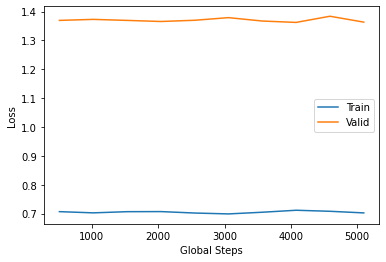

In [ ]:
# 오차 정보를 그래프로 확인
train_loss_list, valid_loss_list, global_steps_list = load_metrics('/content/data/metrics.pt') # 최종적으로 저장된 모델을 로드

plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend();

In [ ]:
# 모델 평가 함수 정의
def evaluate(model, test_loader):
  y_pred = []
  y_true = []

  model.eval()
  with torch.no_grad():
    for text, label in test_loader:
      encoded_list = [tokenizer.encode(t, add_special_tokens=True) for t in text]
      padded_list = [e + [0] * (512-len(e)) for e in encoded_list]
      sample = torch.tensor(padded_list)
      sample, label = sample.to(device), label.to(device)
      labels = torch.tensor(label)
      output = model(sample, labels=label)
      _, output = output
      y_pred.extend(torch.argmax(output, 1).tolist())
      y_true.extend(labels.tolist())

  print('Classification 결과')
  print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

  cm = confusion_matrix(y_true, y_pred, labels=[1,0])
  ax = plt.subplot()
  sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt="d")
  ax.set_title('Confusion Matrix')
  ax.set_xlabel('Predicted Labels')
  ax.set_ylabel('True Labels')
  ax.xaxis.set_ticklabels(['0', '1'])
  ax.yaxis.set_ticklabels(['0', '1'])

Model loaded to <== /content/data/model.pt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Classification 결과
              precision    recall  f1-score   support

           1     0.5091    1.0000    0.6747       558
           0     0.0000    0.0000    0.0000       538

    accuracy                         0.5091      1096
   macro avg     0.2546    0.5000    0.3374      1096
weighted avg     0.2592    0.5091    0.3435      1096



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


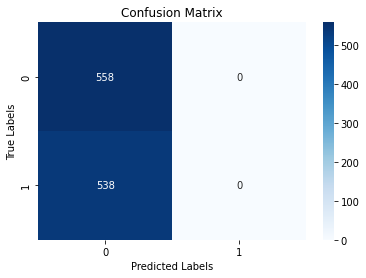

In [ ]:
# 모델 평가
best_model = model.to(device)
load_checkpoint('/content/data/model.pt', best_model)
evaluate(best_model, test_loader)

결과가 좋지 않다. 모델을 훈련하기 위한 데이터가 작았을 뿐더러, 사전 훈련된 모델도 다국어를 지원하는 모델이 아니었다. 

# 한국어 임베딩
- 다국어용 버트 모델인 `bert-base-multilingual-cased`를 사용하여 한국어 임베딩을 시도

In [ ]:
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-8tom6iy_/kobert-tokenizer_ef7fdea594b040b28fa60d68dbde7a54
  Running command git clone -q https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-8tom6iy_/kobert-tokenizer_ef7fdea594b040b28fa60d68dbde7a54
  Created wheel for kobert-tokenizer: filename=kobert_tokenizer-0.1-py3-none-any.whl size=4649 sha256=afcb9377dd288e77e15355293754e24279f67bb1633680a7264f65bd530bbe6a
  Stored in directory: /tmp/pip-ephem-wheel-cache-jxe1epol/wheels/10/b4/d9/cb627bbfaefa266657b0b4e8127f7bf96d27376fa1a23897b4
Successfully built kobert-tokenizer


In [ ]:
# 라이브러리 호출
import torch

from transformers import BertTokenizer, BertModel
from kobert_tokenizer import KoBERTTokenizer

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased') # 다국어를 위한 버트 토크나이저
kobert_tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/244 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/432 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


In [ ]:
# 문장 토크나이징
text = '나는 파이토치를 이용한 딥러닝을 학습중이다.'
marked_text = '[CLS] ' + text + ' [SEP]'  # 문장의 시작은 [CLS], 문장의 끝은 [SEP]의 형태를 맞춤
bert_tokenized_text = bert_tokenizer.tokenize(marked_text)
kobert_tokenized_text = kobert_tokenizer.tokenize(marked_text)

print('multilingual-bert:\n', bert_tokenized_text)
print('kobert:\n', kobert_tokenized_text)

multilingual-bert:
 ['[CLS]', '나는', '파', '##이', '##토', '##치를', '이', '##용한', '딥', '##러', '##닝', '##을', '학', '##습', '##중', '##이다', '.', '[SEP]']
kobert:
 ['[CLS]', '▁나는', '▁파', '이', '토', '치를', '▁이용한', '▁', '딥', '러', '닝', '을', '▁학습', '중', '이다', '.', '[SEP]']


multilingual-bert의 경우 쪼개진 단어가 정확하지 않음을 확인할 수 있다.
- 이것은 버트 토크나이저가 단어의 가장 작은 조각을 기준으로 쪼개도록 설계되었기 때문이다. 
- 따라서 과하다 싶을 정도로 잘게 쪼개져 있다.
- 영어의 경우 단어 기준으로 쪼개지기는 하지만 영어가 아닌 경우 토크나이징이 정확하지 않을 수 있다.

In [ ]:
# 모델을 훈련시킬 텍스트 정의
text = '과수원에 사과가 많았다.'\
       '친구가 나에게 사과했다.'\
       '백설공주는 독이 든 사과를 먹었다.'
marked_text = '[CLS] ' + text + ' [SEP]'

bert_tokenized_text = bert_tokenizer.tokenize(marked_text)  # 문장을 토큰으로 분리
bert_indexed_tokens = bert_tokenizer.convert_tokens_to_ids(bert_tokenized_text) # 토큰 문자열에 인덱스를 매핑

kobert_tokenized_text = kobert_tokenizer.tokenize(marked_text)
kobert_indexed_tokens = kobert_tokenizer.convert_tokens_to_ids(bert_tokenized_text)

In [ ]:
# bert-base-multilingual-cased의 단어와 인덱스 출력
for tup in zip(bert_tokenized_text, bert_indexed_tokens):
  print('{:<12} {:<6,}'.format(tup[0], tup[1]))

[CLS]        101   
과            8,898 
##수          15,891
##원에         108,280
사            9,405 
##과          11,882
##가          11,287
많            9,249 
##았다         27,303
.            119   
친            9,781 
##구          17,196
##가          11,287
나            8,982 
##에게         26,212
사            9,405 
##과          11,882
##했다         12,490
.            119   
백            9,331 
##설          31,928
##공          28,000
##주는         100,633
독            9,088 
##이          10,739
든            9,115 
사            9,405 
##과          11,882
##를          11,513
먹            9,266 
##었다         17,706
.            119   
[SEP]        102   


In [ ]:
# KoBERT의 단어와 인덱스 출력
for tup in zip(kobert_tokenized_text, kobert_indexed_tokens):
  print('{:<12} {:<6,}'.format(tup[0], tup[1]))

[CLS]        2     
▁            5,468 
과            0     
수원           0     
에            6,493 
▁사과          0     
가            0     
▁많았다         6,158 
.            0     
친            54    
구            7,489 
가            0     
▁나           0     
에게           5,655 
▁사과          0     
했다           6,493 
.            0     
백            0     
설            54    
공            6,314 
주는           0     
▁독           0     
이            0     
▁            5,865 
든            0     
▁사과          5,928 
를            6,493 
▁먹           0     
었다           0     
.            6,183 
[SEP]        0     


multilingual-bert의 경우 문장을 구별하기 위해 1과 0을 사용한다. 즉, 문장이 바뀔 때마다 0에서 1로 바뀌고, 또다시 문장이 바뀌면 1에서 0으로 바뀐다. 예를 들어 [0,0,1,1,1,0,0,0]이라는 결과가 있다면 이것은 세 개의 문장으로 구성되었음을 의미한다.  

예제에서는 하나의 문장으로 인식시키기 위해 33개의 토큰에 벡터 1을 부여한다.

In [ ]:
# 문장 인식 단위 지정
bert_segments_ids = [1] * len(bert_tokenized_text)
kobert_segments_ids = [1] * len(kobert_tokenized_text)

print('multilingual-bert:\n', bert_segments_ids)
print('kobert:\n', kobert_segments_ids)

multilingual-bert:
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
kobert:
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
# 모델 생성
model = BertModel.from_pretrained('bert-base-multilingual-cased', output_hidden_states=True)
model.eval()

In [ ]:
# 인덱스와 토크나이징 결과를 텐서로 변환
tokens_tensor = torch.tensor([bert_indexed_tokens])
segments_tensors = torch.tensor([bert_segments_ids])

In [ ]:
# 모델 훈련
with torch.no_grad():   # 모델을 평가할 때는 기울기를 계산하지 않는다.
  outputs = model(tokens_tensor, segments_tensors)
  hidden_states = outputs[2]  # 네트워크의 은닉상태를 가져옴

In [ ]:
# 모델의 은닉 상태 정보 확인
print('계층 개수: ', len(hidden_states), "(initial embeddings + 12 BERT layers)")
layer_i=0

print('배치 개수: ', len(hidden_states[layer_i]))
batch_i=0

print('토큰 개수: ', len(hidden_states[layer_i][batch_i]))

token_i=0
print('은닉층의 유닛 수: ', len(hidden_states[layer_i][batch_i][token_i]))

계층 개수:  13 (initial embeddings + 12 BERT layers)
배치 개수:  1
토큰 개수:  33
은닉층의 유닛 수:  768


계층 개수(13개의 계층으로 구성), 배치 개수(한 개의 문장으로 구성), 토큰 개수(33개의 토큰으로 구성), 은닉층의 유닛 개수(768 특성)로 구성되어 있는 것을 확인 가능. 원래 버트는 12개의 계층으로 구성되어 있지만 최종 13개로 표현되는 이유는 첫번째 임베딩 계층이 포함되었기 때문.  

현재는 네 개의 차원(계층/배치/토큰/은닉층 유닛)으로 구성되어 있지만 이것을 세 개의 차원(토큰/계층/은닉층 유닛)으로 변환해보자.

In [ ]:
# 모델의 은닉 상태 정보 확인
print('은닉 상태의 유형: ', type(hidden_states))
print('각 계층에서의 텐서 형태: ', hidden_states[0].size())

은닉 상태의 유형:  <class 'tuple'>
각 계층에서의 텐서 형태:  torch.Size([1, 33, 768])


각 계층에서의 텐서는 [1, 33, 768]의 형태를 갖는다. 이를 하나의 텐서로 결합하여 보자

In [ ]:
# 텐서의 형태 변경
token_embeddings = torch.stack(hidden_states, dim=0) # 각 계층의 텐서 결합
token_embeddings.size()

torch.Size([13, 1, 33, 768])

우리는 지금 하나의 문장만을 사용하기 때문에 배치 사이즈의 차원은 불필요하다.  
위의 텐서에서 불필요한 '배치' 차원만을 제거해보자

In [ ]:
# 텐서의 형태 변경
token_embeddings = torch.squeeze(token_embeddings, dim=1)
token_embeddings.size()

torch.Size([13, 33, 768])

마지막으로 `permute`를 사용하여 '계층 개수와 '토큰 개수'에 대한 차원의 위치를 바꾸어준다.

In [ ]:
# 텐서의 차원 변경
token_embeddings = token_embeddings.permute(1,0,2)
token_embeddings.size()

torch.Size([33, 13, 768])

In [ ]:
# 각 단어에 대한 벡터 형태 확인
token_vecs_cat = []

for token in token_embeddings:
  cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)
  token_vecs_cat.append(cat_vec)

print('형태는 %d x %d' % (len(token_vecs_cat), len(token_vecs_cat[0])))

형태는 33 x 3072


개별적인 토큰은 [12 × 768]의 형태를 가지며, 네 개의 계층을 이어 붙이면 각 계층의 벡터는 768개의 값을 갖게 되므로, 'cat_vec'의 길이는 3072개가 된다. 이때 'cat_vec'는 토큰을 의미한다.

마지막으로 4개의 계층을 연결하여 단어 벡터를 생성한다.

In [ ]:
# 계층을 결합하여 최종 단어 벡터 생성
token_vecs_sum = []

for token in token_embeddings:
  sum_vec = torch.sum(token[-4:], dim=0)
  token_vecs_sum.append(sum_vec)

print('형태는 %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))

형태는 33 x 768


이제 전체 문장에 대한 단일 벡터를 구해야 한다. 간단하게 768 길이의 벡터를 생성하는 각 토큰의 두 번째에서 마지막 은닉 계층을 평균화하면 구할 수 있다.

In [ ]:
# 문장 벡터
token_vecs = hidden_states[2][0]
sentence_embedding = torch.mean(token_vecs, dim=0)
print('최종 임베딩 벡터의 형태', sentence_embedding.size())

최종 임베딩 벡터의 형태 torch.Size([768])


tokenized_text에서 토큰들을 꺼내서 인덱스와 함께 출력

In [ ]:
# 토큰과 인덱스 출력
for i, token_str in enumerate(bert_tokenized_text):
  print(i, token_str)

0 [CLS]
1 과
2 ##수
3 ##원에
4 사
5 ##과
6 ##가
7 많
8 ##았다
9 .
10 친
11 ##구
12 ##가
13 나
14 ##에게
15 사
16 ##과
17 ##했다
18 .
19 백
20 ##설
21 ##공
22 ##주는
23 독
24 ##이
25 든
26 사
27 ##과
28 ##를
29 먹
30 ##었다
31 .
32 [SEP]


코드에서 '사과'는 4, 5, 15, 16, 26, 27에 있다. 원래는 붙어 있어야 하나의 단어가 되지만 쪼개진 상태에서 어떠한 결과를 보여 주는지 알아보도록 한다.

In [ ]:
# 단어 벡터 확인
print('사과가 많았다.', str(token_vecs_sum[6][:5]))
print('나에게 사과했다.', str(token_vecs_sum[10][:5]))
print('사과를 먹었다', str(token_vecs_sum[19][:5]))

사과가 많았다. tensor([-0.5844, -4.0836,  0.4906,  0.8915, -1.8054])
나에게 사과했다. tensor([-0.8631, -3.4047, -0.7351,  0.9805, -2.6700])
사과를 먹었다 tensor([ 0.6756, -0.3618,  0.0586,  2.2050, -2.4193])


정확한 비교를 위해 코사인 유사도를 측정해보자

In [ ]:
# 코사인 유사도 계산
from scipy.spatial.distance import cosine

# '사과가 많았다'와 '나에게 사과했다'에서 단어 '사과' 사이의 코사인 유사도를 계산
diff_apple = 1 - cosine(token_vecs_sum[5], token_vecs_sum[27])  

# '사과가 많았다'와 '사과를 먹었다'에서 단어 '사과' 사이의 코사인 유사도를 계산
same_apple = 1 - cosine(token_vecs_sum[5], token_vecs_sum[19])

print('*유사한* 의미에 대한 벡터 유사성:  %.2f' % same_apple)
print('*다른* 의미에 대한 벡터 유사성:  %.2f' % diff_apple)

*유사한* 의미에 대한 벡터 유사성:  0.58
*다른* 의미에 대한 벡터 유사성:  0.91


다국어 버트 모델을 사용하더라도 한국어에 대해서는 정확한 판별이 쉽지 않음을 볼 수 있다. 또한 사과라는 단어가 한 번 더 쪼개져 있기 때문에 정확한 결과라고 하기도 힘들다. 한국어에 대한 임베딩은 국내에서 개발된 모델을 이용하는 것이 정확도가 더 높기 때문에 KoBert 같은 모델을 사용하는 것이 좋다.